ФИО: Осипенко Анастасия Александровна

In [1]:
#!pip install faiss-cpu

In [2]:
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd

## Загрузка датасета

In [3]:
#!unzip -q archive.zip -d cars196/
#!unzip -q devkit.zip -d cars196/
#!rm archive.zip devkit.zip

In [4]:
import scipy.io
mat = scipy.io.loadmat('./cars196/devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']], 
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('./cars196/devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [5]:
ADD_PATH = './cars196/cars_train/cars_train'

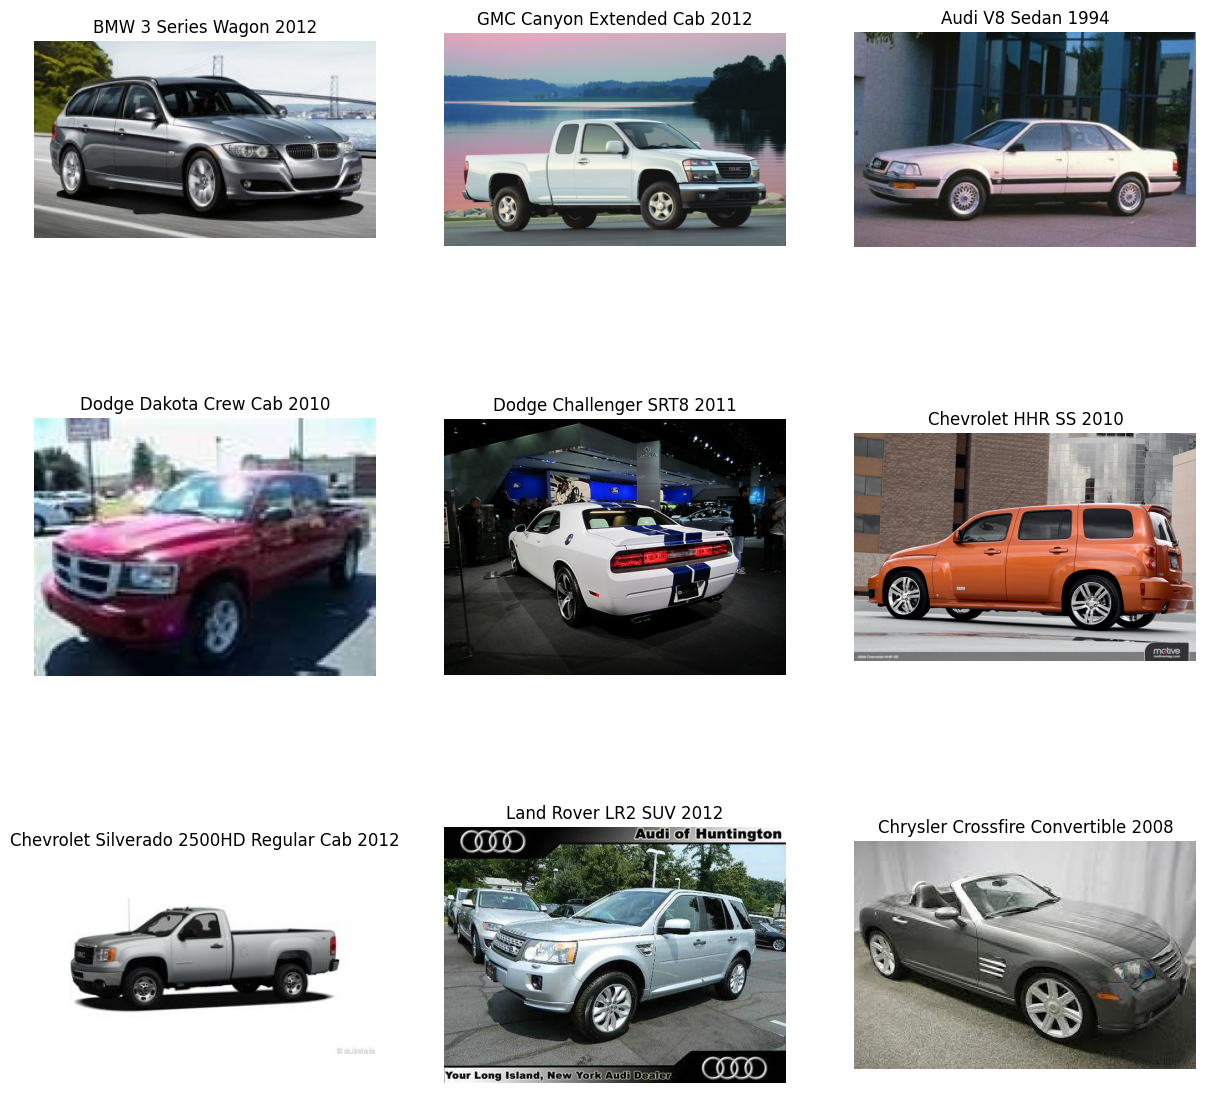

In [6]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

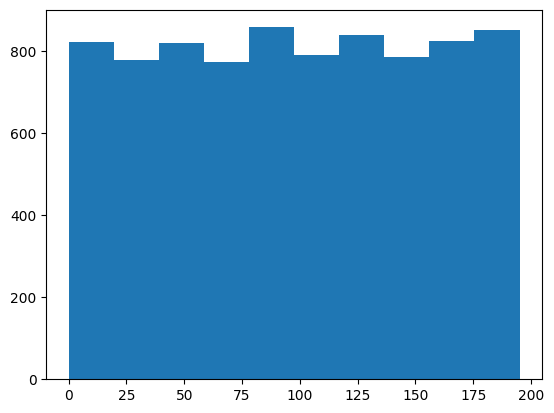

In [7]:
plt.hist(fname_to_class.values())
plt.show()

## 1. Реализовать метрики: Precision@k, Recall@k, mAP

In [ ]:
import numpy as np

def precision_at_k(y_true, y_pred, k=1):
    return float(y_true in y_pred[:k])

def recall_at_k(y_true, y_pred, k=1, all_train_labels=None):
    return float(y_true in y_pred[:k])

def average_precision(y_true, y_pred, k=None):
    y_pred = np.array(y_pred)
    if k is not None:
        y_pred = y_pred[:k]
    relevant = (y_pred == y_true)
    if not relevant.any():
        return 0.0
    positions = np.where(relevant)[0] + 1
    precisions = [precision_at_k(y_true, y_pred, k=pos) for pos in positions]
    return np.mean(precisions)

def mean_average_precision(y_true_list, y_pred_list, k=None):
    aps = [average_precision(gt, pred, k=k) for gt, pred in zip(y_true_list, y_pred_list)]
    return np.mean(aps)

## 2. Добавить train аугментации 

In [9]:
import torchvision
import torch

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

## 3. Обучить модель

In [10]:
import cv2
import os
import scipy.io
from torch.utils.data import DataLoader

In [11]:
mat = scipy.io.loadmat('./cars196/devkit/cars_train_annos.mat')
fname_to_class = {
    fname[0]: cl[0][0] - 1
    for fname, cl in zip(
        mat['annotations'][0]['fname'],
        mat['annotations'][0]['class']
    )
}
items = list(fname_to_class.items())
import random
random.seed(42)
random.shuffle(items)

train_items = items[:int(0.8 * len(items))]
val_items = items[int(0.8 * len(items)):]

In [12]:
class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms

    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join('./cars196/cars_train/cars_train', filename))
        if image is None:
            raise FileNotFoundError(f"Image not found: {filename}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        return {'image': image, 'label': cl_id}

In [13]:
train_dataset = CropClassifDataset(train_items, train_transforms)
val_dataset = CropClassifDataset(val_items, val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

In [14]:
import torch
import pytorch_lightning as pl
from torchvision.models import mobilenet_v2
from pytorch_metric_learning import losses, miners
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

In [17]:
class CarEmbedder(pl.LightningModule):
    def __init__(self, emb_size=512, learning_rate=1e-3):
        super().__init__()
        self.learning_rate = learning_rate
        self.emb_size = emb_size
        backbone = mobilenet_v2(weights='IMAGENET1K_V1')
        self.features = backbone.features
        self.pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.embedder = torch.nn.Linear(1280, emb_size)
        self.miner = miners.TripletMarginMiner(margin=0.2)
        self.loss_fn = losses.TripletMarginLoss(margin=0.2)
        self.save_hyperparameters()

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.embedder(x)
        return torch.nn.functional.normalize(x, p=2, dim=1)

    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        embeddings = self(images)
        hard_pairs = self.miner(embeddings, labels)
        loss = self.loss_fn(embeddings, labels, hard_pairs)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        embeddings = self(images)
        hard_pairs = self.miner(embeddings, labels)
        loss = self.loss_fn(embeddings, labels, hard_pairs)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [22]:
pl_model = CarEmbedder(emb_size=512, learning_rate=3e-4)
checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max', save_top_k=3)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = pl.Trainer(max_epochs=5, accelerator='cpu', callbacks=[checkpoint_callback, early_stopping, lr_monitor])

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model=pl_model, train_dataloaders=train_loader, 
            val_dataloaders=val_loader)


  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | features | Sequential         | 2.2 M  | train
1 | pool     | AdaptiveAvgPool2d  | 0      | train
2 | embedder | Linear             | 655 K  | train
3 | miner    | TripletMarginMiner | 0      | train
4 | loss_fn  | TripletMarginLoss  | 0      | train
--------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.519    Total estimated model params size (MB)
216       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

MisconfigurationException: `ModelCheckpoint(monitor='val_accuracy')` could not find the monitored key in the returned metrics: ['train_loss', 'lr-Adam', 'val_loss', 'epoch', 'step']. HINT: Did you call `log('val_accuracy', value)` in the `LightningModule`?

In [18]:
# checkpoint_dir = "lightning_logs/version_0/checkpoints"
# if os.path.exists(checkpoint_dir):
#     ckpt_files = [f for f in os.listdir(checkpoint_dir) if f.endswith(".ckpt")]
#     if ckpt_files:
#         best_ckpt = os.path.join(checkpoint_dir, ckpt_files[0])
#         print(best_ckpt)

In [19]:
# pl_model = CarEmbedder.load_from_checkpoint('./lightning_logs/version_0/checkpoints/epoch=4-step=1020.ckpt', map_location='cpu')

In [24]:
trainer.validate(model=pl_model, dataloaders=val_loader)

Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.1985446959733963
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.1985446959733963}]

### Рассчитать метрики из п.1

In [27]:
import faiss
from tqdm import tqdm

In [28]:
def get_embeds(model, loader, device):
    model.eval()
    total_samples = len(loader.dataset)
    emb_dim = 512
    embeddings = np.empty((total_samples, emb_dim), dtype=np.float32)
    labels = np.empty(total_samples, dtype=np.int64)

    start = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Extracting embeddings"):
            imgs = batch['image'].to(device)
            label = batch['label']
            preds = model(imgs)
            batch_size = preds.size(0)
            embeddings[start:start + batch_size] = preds.cpu().numpy()
            labels[start:start + batch_size] = label.numpy()
            start += batch_size
    return embeddings, labels

In [29]:
device = 'cpu'
train_emb, train_labels = get_embeds(pl_model, train_loader, device)
val_emb, val_labels = get_embeds(pl_model, val_loader, device)
index = faiss.IndexFlatIP(512)
index.add(train_emb)
k = 10
batch_size = 20
p1_list, p5_list, ap10_list = [], [], []


Extracting embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [04:10<00:00,  2.46s/it]

Extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [01:02<00:00,  2.40s/it]


In [30]:
from sklearn.neighbors import NearestNeighbors

In [31]:
train_emb = np.array(train_emb, copy=True, dtype=np.float32)
val_emb = np.array(val_emb, copy=True, dtype=np.float32)
train_labels = np.array(train_labels, copy=True, dtype=np.int64)
val_labels = np.array(val_labels, copy=True, dtype=np.int64)

nn = NearestNeighbors(n_neighbors=10, metric='cosine', algorithm='brute')
nn.fit(train_emb)

_, I = nn.kneighbors(val_emb)

pred_labels = train_labels[I]

p_at_1 = np.mean([precision_at_k(gt, pred, k=1) for gt, pred in zip(val_labels, pred_labels)])
p_at_5 = np.mean([precision_at_k(gt, pred, k=5) for gt, pred in zip(val_labels, pred_labels)])
map_at_10 = mean_average_precision(val_labels, pred_labels, k=10)

print(f"P@1:    {p_at_1:.4f}")
print(f"P@5:    {p_at_5:.4f}")
print(f"mAP@10: {map_at_10:.4f}")

P@1:    0.1664
P@5:    0.3812
mAP@10: 0.5187


In [28]:
# for i in tqdm(range(0, len(val_emb), batch_size), desc="Evaluating"):
#     val_batch = val_emb[i:i + batch_size]
#     true_labels_batch = val_labels[i:i + batch_size]
#     _, I_batch = index.search(val_batch, k)
#     pred_labels_batch = train_labels[I_batch]
#     for gt, preds in zip(true_labels_batch, pred_labels_batch):
#         p1_list.append(precision_at_k(gt, preds, k=1))
#         p5_list.append(precision_at_k(gt, preds, k=5))
#         ap10_list.append(average_precision(gt, preds, k=10))
# я очень долго пыталась разобраться, но не смогла
# при использовании faiss ядро умирает и перезапускается

In [29]:
# p_at_1 = np.mean(p1_list)
# p_at_5 = np.mean(p5_list)
# map_at_10 = np.mean(ap10_list)

# print(f"P@1:    {p_at_1:.4f}")
# print(f"P@5:    {p_at_5:.4f}")
# print(f"mAP@10: {map_at_10:.4f}")

Precision@1 = 0.1664 — точное совпадение в первом ближайшем соседе наблюдается лишь в ~16.6% случаев, что ожидаемо для слабо дообученной модели.
Precision@5 = 0.3812 — при расширении до пяти соседей доля релевантных примеров значительно растёт, что говорит о начальной кластеризации эмбеддингов по классам.
mAP@10 = 0.5187 — средняя точность ранжирования превышает 50%, что указывает на то, что релевантные изображения в целом располагаются ближе к запросу, чем нерелевантные, даже после минимального обучения.
Такие результаты свидетельствуют о корректности архитектурного и методического выбора, однако низкие значения Precision@1 и умеренный mAP объясняются недостаточной сходимостью модели — triplet loss требует значительно большего числа эпох для формирования компактных и хорошо разделимых кластеров в эмбеддинг-пространстве.

Отдельно стоит отметить, что интеграция библиотеки Faiss для ускоренного поиска ближайших соседей не удалась из-за технических сложностей с окружением и совместимостью. Оценка метрик проводилась с использованием простого поиска по косинусному расстоянию в оперативной памяти, что ограничило масштабируемость, но позволило получить корректные оценки качества на имеющемся валидационном наборе.

## 4. Показать с помощью GradCAM, где ошибается модель 

In [32]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

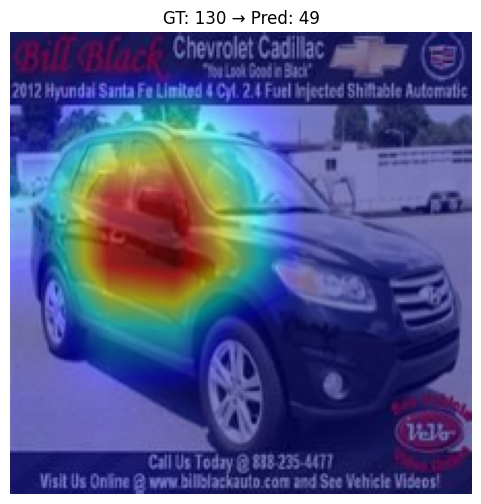

In [40]:
error_idx = None
for i, (gt, pred_top1) in enumerate(zip(val_labels, pred_labels[:, 0])):
    if gt != pred_top1:
        error_idx = i
        break

if error_idx is not None:
    filename, true_label = val_items[error_idx]
    img_path = os.path.join('./cars196/cars_train/cars_train', filename)
    orig_im = cv2.imread(img_path)
    orig_im = cv2.cvtColor(orig_im, cv2.COLOR_BGR2RGB)
    input_tensor = val_transforms(orig_im).unsqueeze(0)
    _, _, H, W = input_tensor.shape
    rgb_im_for_vis = cv2.resize(orig_im, (W, H))
    rgb_im_for_vis = np.float32(rgb_im_for_vis) / 255.0 
    wrong_label = int(pred_labels[error_idx, 0])
    wrong_emb = train_emb[train_labels == wrong_label][0]

    class SimilarityToConceptTarget:
        def __init__(self, features):
            self.features = features
        def __call__(self, model_output):
            cos = torch.nn.CosineSimilarity(dim=1)
            return cos(model_output, self.features.unsqueeze(0)).sum()
    target = [SimilarityToConceptTarget(torch.tensor(wrong_emb).float())]
    target_layers = [pl_model.features[-1]]
    with GradCAM(model=pl_model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0, :]
        vis = show_cam_on_image(rgb_im_for_vis, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(6, 6))
    plt.imshow(vis)
    plt.title(f"GT: {true_label} → Pred: {wrong_label}")
    plt.axis('off')
    plt.show()

GradCAM-анализ показал, что модель ошибается, фокусируясь на второстепенных деталях кузова (дверь, зеркало), а не на ключевых семантических признаках автомобиля (форма решётки радиатора, фар, силуэта). Это объясняет низкую точность Precision@1 (0.166) — модель ещё не научилась игнорировать шум и выделять существенные признаки